In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
def create_fast(X):
    """Create bigger matrix filled with x - y pairs."""
    n, d = X.shape
    pairs = np.kron(np.ones((n, 1)), X) - np.kron(X, np.ones((n, 1)))
    rk1_matrices = np.kron(np.ones((1, d)), pairs) * np.kron(pairs, np.ones((1, d)))
    return rk1_matrices

In [3]:
def hinge(u, y, b):
    """Hinge loss."""
    return np.maximum(0, 1 - y * (b - u))

In [4]:
def create_mahalanobis(M):
    """Squared Mahalanobis distance."""
    return lambda x, y: (x - y) @ M @ (x - y)

In [5]:
def create_fast_mahalanobis(flat_M):
    """Fast version of Mahalanobis (memory-expensive)."""
    return lambda big_x: flat_M @ big_x

In [6]:
def loss(M, X, y, b=2, fast_X=None):
    """Hinge loss for metric learning."""
    if fast_X is None:
        fast_X = create_fast(X)
    # fast_dist = create_fast_mahalanobis(M.ravel())
    all_dists = fast_X @ M.ravel()
    pair_y = np.kron(y, y)
    return np.average(hinge(all_dists, pair_y, b))

In [7]:
def grad_dist(M, X, y, b=2, fast_X=None):
    """Gradient of the hinge loss."""
    if fast_X is None:
        fast_X = create_fast(X)
    pair_y = np.kron(y, y)
    all_dists = fast_X @ M.ravel()
    return np.sum(
        np.outer(pair_y * (hinge(all_dists, pair_y, b) > 0), np.ones(fast_X.shape[1]))
        * fast_X,
        axis=0,
    ).reshape(M.shape)

In [8]:
def positive_cone(M):
    """Project on the semi-definite positive cone."""
    eigval, eigvec = np.linalg.eigh(M)
    projected_eigval = (eigval > 0) * eigval
    return (projected_eigval * eigvec.T) @ eigvec

In [9]:
def create_mini_batch(X, y, batch_size):
    """Randomly select a mini-batch from the data."""
    indices = np.random.choice(X.shape[0], batch_size, replace=False)
    return X[indices], y[indices]

In [10]:
n = 400
d = 5
mu_0 = np.zeros(d)
mu_0[0] = 1.0
mu_1 = np.zeros(d)
mu_1[0] = -1.0
cov = 0.01 * np.eye(d)
X = np.zeros((2 * n, d))
y = np.zeros(2 * n, dtype=int)
X[:n] = np.random.multivariate_normal(mu_0, cov, n)
y[:n] = 1
X[n:] = np.random.multivariate_normal(mu_1, cov, n)
y[n:] = -1

In [11]:
shuffled_indices = np.random.permutation(X.shape[0])
X, y = X[shuffled_indices], y[shuffled_indices]

validation_ratio = 0.2
n_train = int((1 - validation_ratio) * X.shape[0])

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:], y[n_train:]

In [12]:
step = 5e-4

n_iter = 5000
b = 1.1
batch_size = 64
score = np.zeros(n_iter + 1)

In [13]:
fast_X_val = create_fast(X_val)

# Case with M initiliased randomly

In [14]:
M = np.random.randn(d, d)
score = np.zeros(n_iter + 1)
score[0] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)
for i in range(n_iter):
    X_batch, y_batch = create_mini_batch(X, y, batch_size)
    fast_X_batch = create_fast(X_batch)
    M = positive_cone(
        M - step * grad_dist(M, X_batch, y_batch, b=b, fast_X=fast_X_batch)
    )
    # score on val
    score[i + 1] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)

    if i % 500 == 0:
        print(f"iter {i+1}, score {score[i+1]}")

        if score[i + 1] > score[i - 499] and i > 0:
            break

iter 1, score 0.029779800910690338
iter 501, score 0.0009529159343121471
iter 1001, score 0.009572220659951057


c:\Users\louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


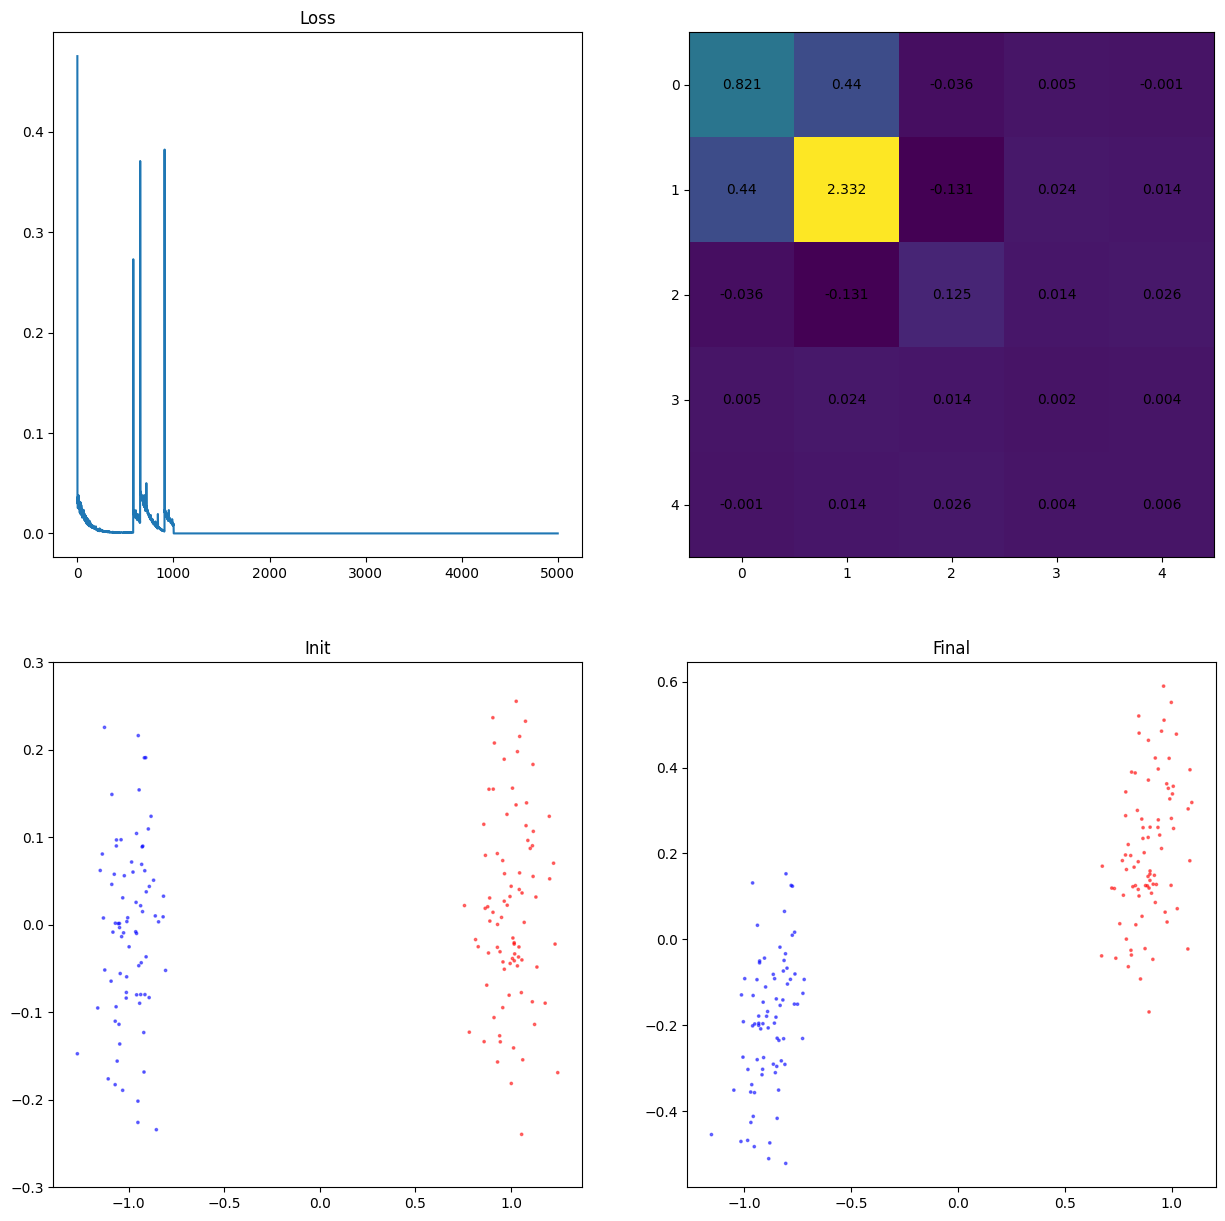

In [15]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(score)
plt.title("Loss")

plt.subplot(2, 2, 3)
colors = np.array(["b", "r"])
plt.scatter(X_val[:, 0], X_val[:, 1], color=colors[(y_val > 0) * y_val], s=3, alpha=0.5)
plt.ylim([-0.3, 0.3])
plt.title("Init")

plt.subplot(2, 2, 4)
sqrt_M = scipy.linalg.sqrtm(M)
transf_X = X_val @ sqrt_M
plt.scatter(
    transf_X[:, 0], transf_X[:, 1], color=colors[(y_val > 0) * y_val], s=3, alpha=0.5
)
# plt.ylim([-0.3, 0.3])
plt.title("Final")

plt.subplot(2, 2, 2)
plt.imshow(M)
for (j, i), label in np.ndenumerate(M):
    plt.text(i, j, np.round(label, 3), ha="center", va="center")
plt.show()

# Case with M initiliased as identity matrix

In [16]:
M = np.eye(d)
score = np.zeros(n_iter + 1)
score[0] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)
for i in range(n_iter):
    X_batch, y_batch = create_mini_batch(X, y, batch_size)
    fast_X_batch = create_fast(X_batch)
    M = positive_cone(
        M - step * grad_dist(M, X_batch, y_batch, b=b, fast_X=fast_X_batch)
    )

    # score on val
    score[i + 1] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)

    if i % 500 == 0:
        print(f"iter {i+1}, score {score[i+1]}")

        if score[i + 1] > score[i - 499] and i > 0:
            break

iter 1, score 0.01206568846645608
iter 501, score 0.0002085219806772084
iter 1001, score 0.007449985843889675


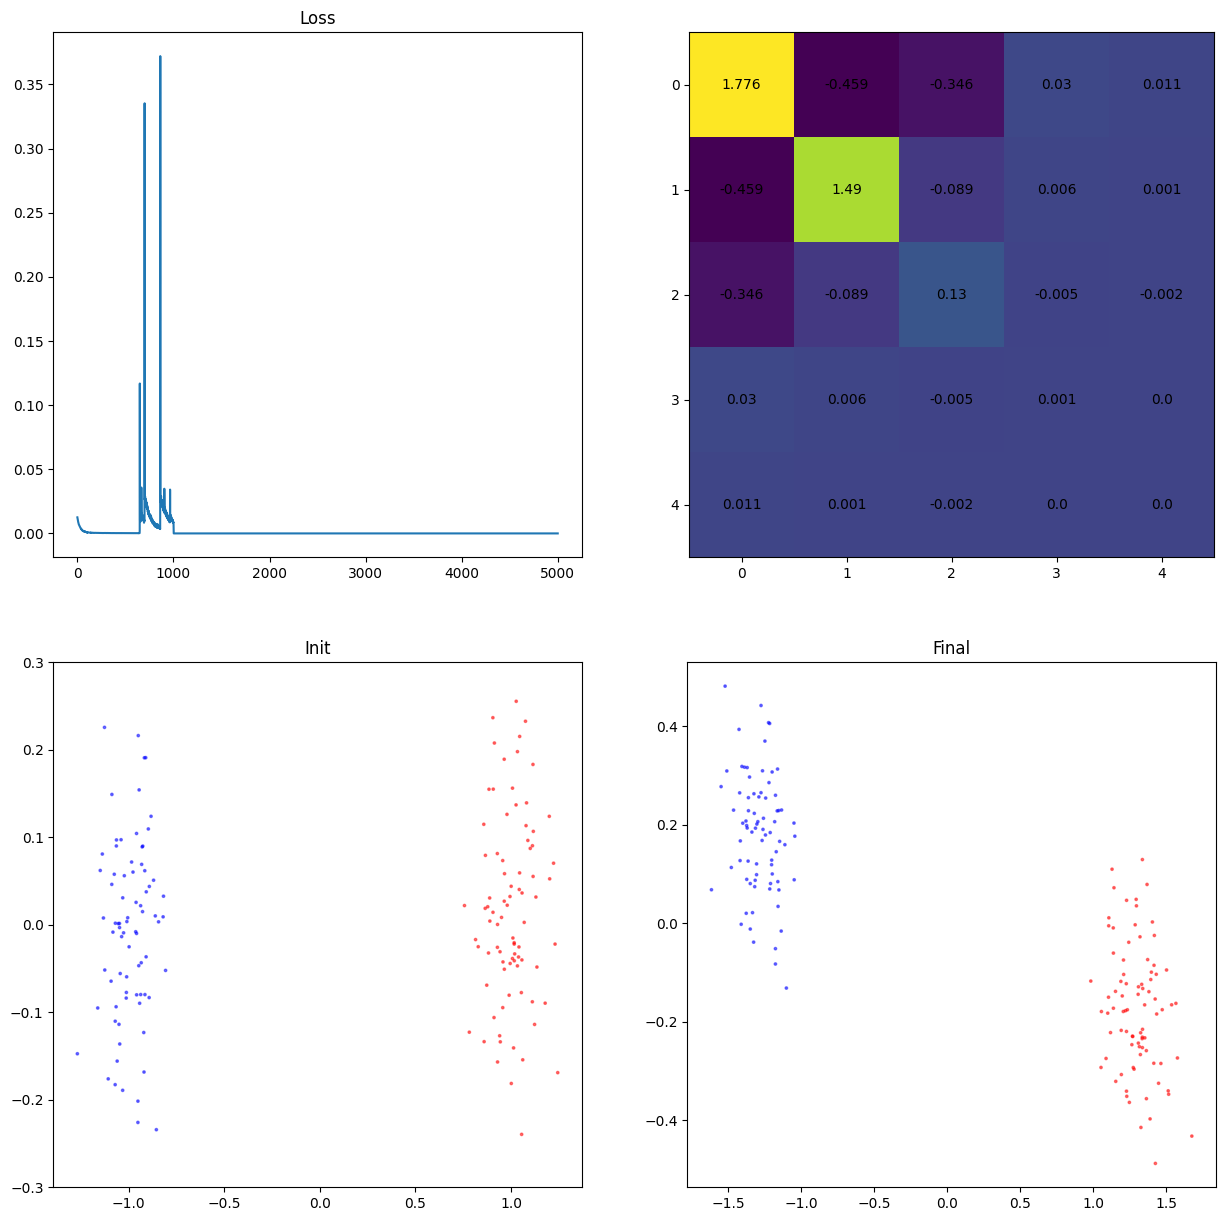

In [17]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(score)
plt.title("Loss")

plt.subplot(2, 2, 3)
colors = np.array(["b", "r"])
plt.scatter(X_val[:, 0], X_val[:, 1], color=colors[(y_val > 0) * y_val], s=3, alpha=0.5)
plt.ylim([-0.3, 0.3])
plt.title("Init")

plt.subplot(2, 2, 4)
sqrt_M = scipy.linalg.sqrtm(M)
transf_X = X_val @ sqrt_M
plt.scatter(
    transf_X[:, 0], transf_X[:, 1], color=colors[(y_val > 0) * y_val], s=3, alpha=0.5
)
# plt.ylim([-0.3, 0.3])
plt.title("Final")

plt.subplot(2, 2, 2)
plt.imshow(M)
for (j, i), label in np.ndenumerate(M):
    plt.text(i, j, np.round(label, 3), ha="center", va="center")
plt.show()

# Case with M initiliased as 0

In [18]:
M = np.zeros((d, d))
score = np.zeros(n_iter + 1)
score[0] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)
for i in range(n_iter):
    X_batch, y_batch = create_mini_batch(X, y, batch_size)
    fast_X_batch = create_fast(X_batch)
    M = positive_cone(
        M - step * grad_dist(M, X_batch, y_batch, b=b, fast_X=fast_X_batch)
    )
    # score on val
    score[i + 1] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)

    if i % 500 == 0:
        print(f"iter {i+1}, score {score[i+1]}")

        if score[i + 1] > score[i - 499] and i > 0:
            break

iter 1, score 0.018223424819907904
iter 501, score 0.0009176240503881214
iter 1001, score 0.012999405872151527


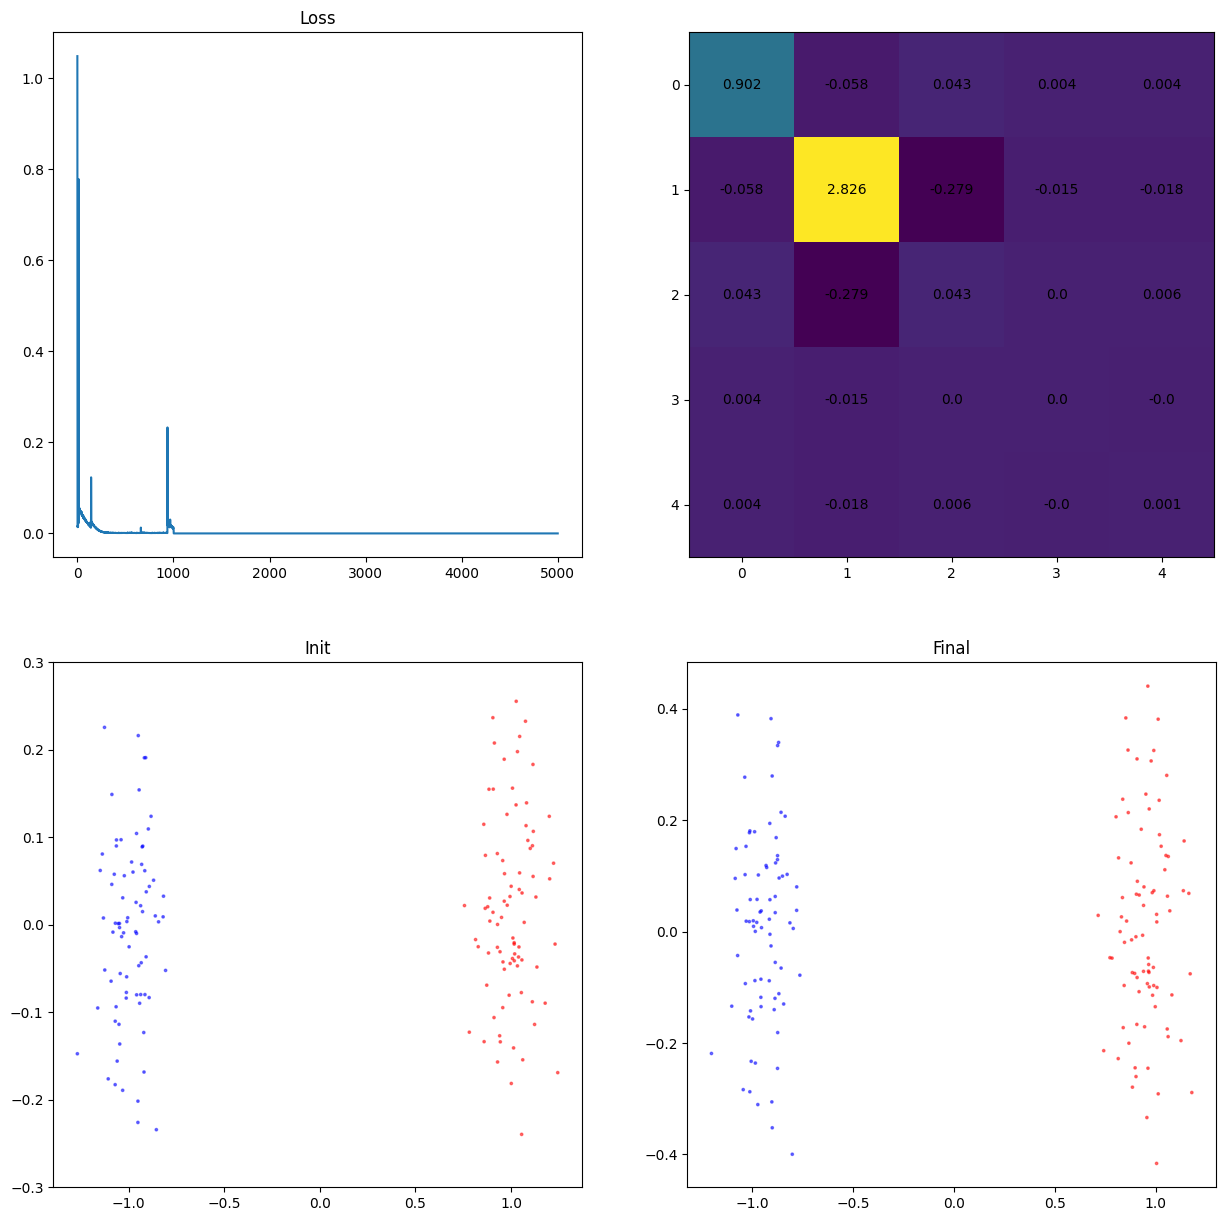

In [19]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(score)
plt.title("Loss")

plt.subplot(2, 2, 3)
colors = np.array(["b", "r"])
plt.scatter(X_val[:, 0], X_val[:, 1], color=colors[(y_val > 0) * y_val], s=3, alpha=0.5)
plt.ylim([-0.3, 0.3])
plt.title("Init")

plt.subplot(2, 2, 4)
sqrt_M = scipy.linalg.sqrtm(M)
transf_X = X_val @ sqrt_M
plt.scatter(
    transf_X[:, 0], transf_X[:, 1], color=colors[(y_val > 0) * y_val], s=3, alpha=0.5
)
# plt.ylim([-0.3, 0.3])
plt.title("Final")

plt.subplot(2, 2, 2)
plt.imshow(M)
for (j, i), label in np.ndenumerate(M):
    plt.text(i, j, np.round(label, 3), ha="center", va="center")
plt.show()

# Ideal solution

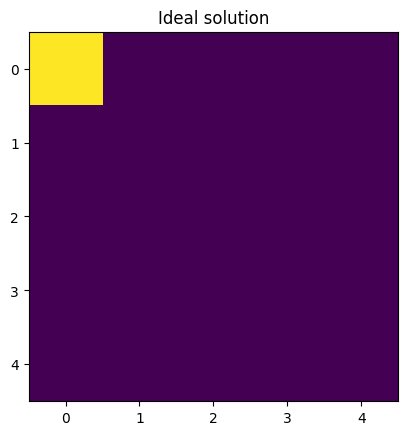

In [26]:
M = np.zeros((d, d))
M[0, 0] = 1
plt.imshow(M)
plt.title("Ideal solution")
plt.show()

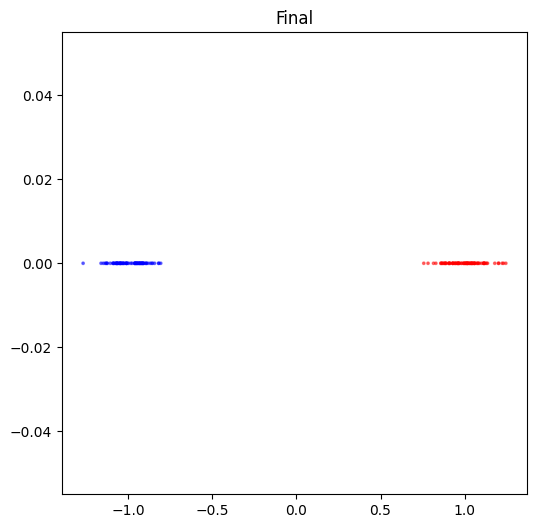

In [27]:
plt.figure(figsize=(6, 6))
sqrt_M = scipy.linalg.sqrtm(M)
transf_X = X_val @ sqrt_M
plt.scatter(
    transf_X[:, 0], transf_X[:, 1], color=colors[(y_val > 0) * y_val], s=3, alpha=0.5
)
# plt.ylim([-0.3, 0.3])
plt.title("Final")

plt.show()

# Case with no batch

In [32]:
M = np.eye(d)
score = np.zeros(n_iter + 1)
score[0] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)
for i in range(n_iter):
    # X_batch, y_batch = create_mini_batch(X, y, batch_size)
    fast_X_batch = create_fast(X_train)
    M = positive_cone(
        M - step * grad_dist(M, X_train, y_train, b=b, fast_X=fast_X_batch)
    )

    # score on val
    score[i + 1] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)

    if i % 500 == 0:
        print(f"iter {i+1}, score {score[i+1]}")

        if score[i + 1] > score[i - 499] and i > 0:
            break

    if score[i + 1] < 0.0001:
        break

iter 1, score 1.0485234375
iter 501, score 2.4199182899980296


c:\Users\louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


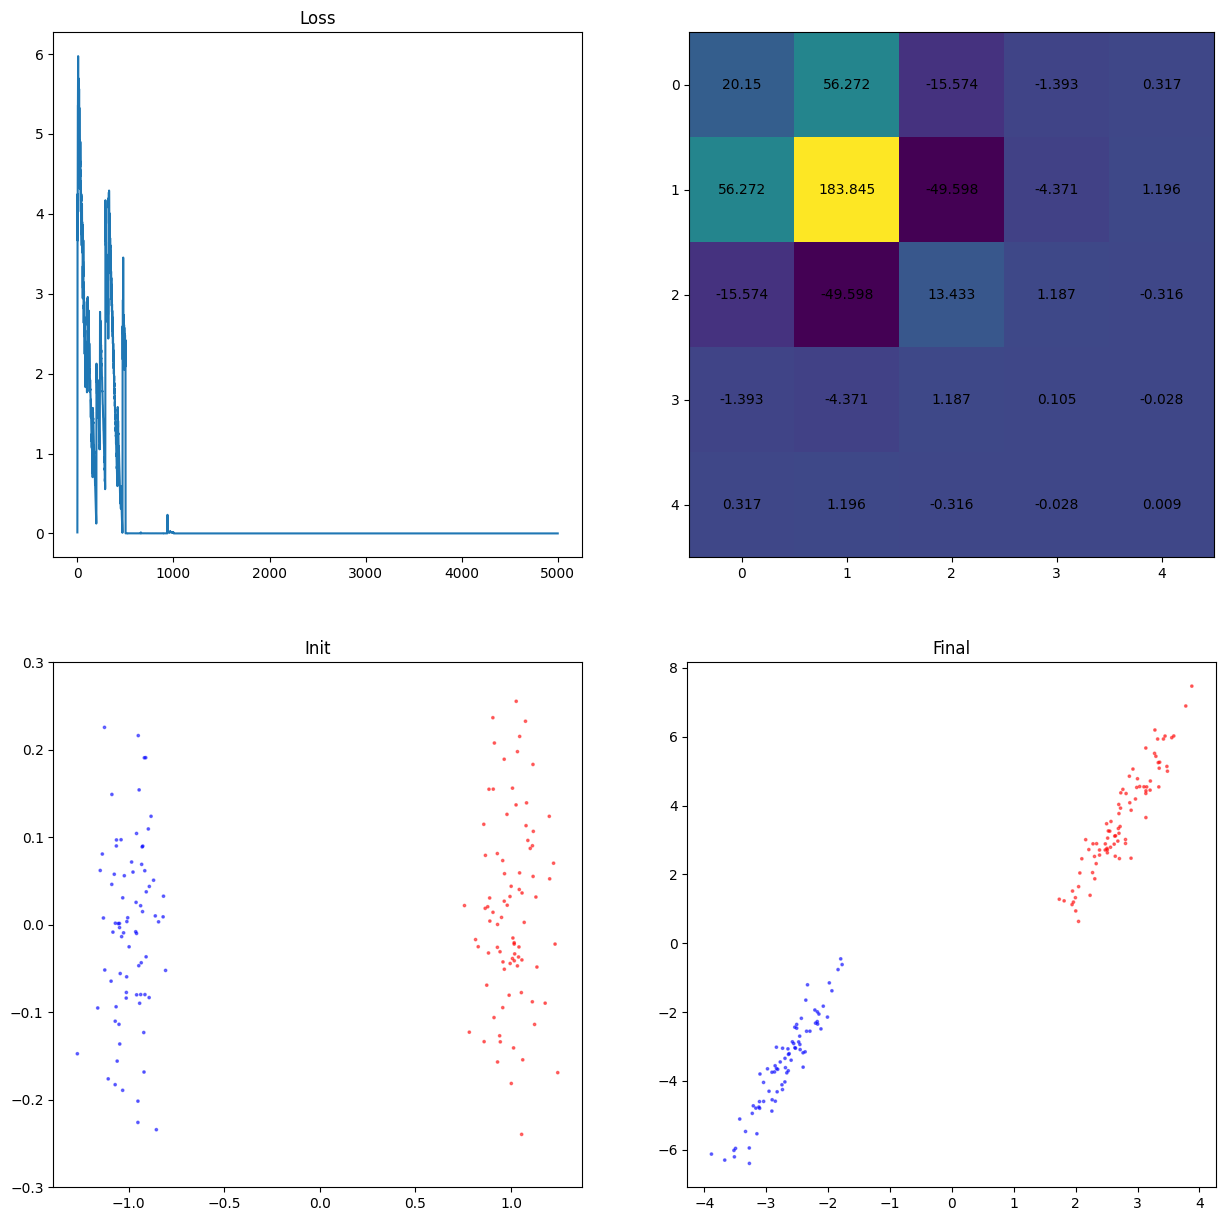

In [33]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(score)
plt.title("Loss")

plt.subplot(2, 2, 3)
colors = np.array(["b", "r"])
plt.scatter(X_val[:, 0], X_val[:, 1], color=colors[(y_val > 0) * y_val], s=3, alpha=0.5)
plt.ylim([-0.3, 0.3])
plt.title("Init")

plt.subplot(2, 2, 4)
sqrt_M = scipy.linalg.sqrtm(M)
transf_X = X_val @ sqrt_M
plt.scatter(
    transf_X[:, 0], transf_X[:, 1], color=colors[(y_val > 0) * y_val], s=3, alpha=0.5
)
# plt.ylim([-0.3, 0.3])
plt.title("Final")

plt.subplot(2, 2, 2)
plt.imshow(M)
for (j, i), label in np.ndenumerate(M):
    plt.text(i, j, np.round(label, 3), ha="center", va="center")
plt.show()